# Regression mit Tensorflow
In diesem Tutorial wollen wir mit Hilfe von Tensorflow eine Neuronales Netz trainieren, dass eine vorgegebene Funktion durch Regression annähern soll

## Definition einer Sinusfunktion
Zunächst definieren wir die folgende Sinusfunktion: $y=\sin(2\pi(x_1+0.5x_2))+0.5x_2)$ <br>Dies ist unsere Zielfunktion, die wir mittels nicht-linearer Regression auf ein Neuronales Netz abbilden wollen.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

def sinus_func(x: np.ndarray):
    return np.sin(2 * np.pi * (x[:, 0] + 0.5 * x[:, 1])) + 0.5 * x[:, 1]

## Erstellen von Trainings-, Validierungs- und Testdaten

Unsere Trainings-, Validierungs und Testdaten generieren wir, indem jeweils für eine bestimmte Menge zufällig generierter Werte zwischen 0 und 1 die Funktionswerte der zuvor definieretn Sinusfunktion berechnet werden. Unsere Traininsgdaten werden außerdem künstlich mit Zufallszahlen verrauscht.

In [2]:
# Generieren von verrauschten Trainingsdaten
x_train = np.random.rand(2500, 2)
y_train = sinus_func(x_train)
noise = np.random.rand(y_train.shape[0]) - 0.5
y_train = (1 + 0.05 * noise) * y_train

# Generieren von Validierungsdaten
x_valid = np.random.rand(500, 2)
y_valid = sinus_func(x_valid)

# Generieren von Testdaten
x_test = np.random.rand(500, 2)
y_test = sinus_func(x_test)

## Lineares Regressionsmodell
### Training
Wir beginnen mit dem Trainieren eines einfachen linearen Regressionsmodells der Form $y=w_1x_1 + w_2x_2+w_3$
Hierzu definieren wir ein sequentielles Tensorflow Modell mit lediglich einem Layer, der einen Output besitzt. Dieser Output ist der vom Modell vorhergesagte, angenäherte Funktionswert der Sinusfunktion.

In [3]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

Dieses einfachen Modell können wir nun mit den generierten Trainigsdaten trainieren. Hierzu müssen wir jedoch einige Konfigurationen unseres Modells mit der `Model.compile()` Methode vornehmen, wie etwa die Verlustfunktion (`loss`), einen Optimirier (`optimizer`) zur automatischen Anpassung des Lernfortschritts sowie weitere Metriken zur Beurteilung der Qualität unseres Modells während des Trainings und Testens.

Für den Trainingsvorgang können außerdem die Größe des Batches sowie die Anzahl der Epochen definiert werden. Diese lassen wir jedoch zunächst variabel und definieren sie als Funktionsparameter der folgenden Methode.

In [4]:
def compile_and_fit(model: tf.keras.Model, inputs: np.ndarray, targets: np.ndarray,
                    validation: tuple, batch_size: int, epochs: int):
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.losses.MeanSquaredError(), tf.metrics.MeanAbsoluteError()])

    history = model.fit(x=inputs, y=targets,
                        validation_data=validation,
                        batch_size=batch_size,
                        epochs=epochs)
    return history

Mit der zuvor definieretn Hilfsfunktion trainieren wir nun unser lineares Modell mit einer Batch-Größe von 32 für 20 Epochen. D.h. unser Modell vearbeitet gleichzeitig 32 Samples um eine einzelne Aktualisierung der Gewichte zu berechnen. Dabei wird die gesamte Trainingsmenge insgesamt 20 mal durchlaufen.

In [5]:
history = compile_and_fit(model=linear_model, inputs=x_train, targets=y_train,
                          validation=(x_valid, y_valid), batch_size=32, epochs=20)

Train on 2500 samples, validate on 500 samples
Epoch 1/20
2500/2500 [==============================] - 0s 189us/sample - loss: 0.8050 - mean_squared_error: 0.8114 - mean_absolute_error: 0.7570 - val_loss: 0.8090 - val_mean_squared_error: 0.8051 - val_mean_absolute_error: 0.7563
Epoch 2/20
2500/2500 [==============================] - 0s 41us/sample - loss: 0.7788 - mean_squared_error: 0.7805 - mean_absolute_error: 0.7468 - val_loss: 0.7824 - val_mean_squared_error: 0.7786 - val_mean_absolute_error: 0.7459
Epoch 3/20
2500/2500 [==============================] - 0s 40us/sample - loss: 0.7543 - mean_squared_error: 0.7481 - mean_absolute_error: 0.7370 - val_loss: 0.7571 - val_mean_squared_error: 0.7533 - val_mean_absolute_error: 0.7360
Epoch 4/20
2500/2500 [==============================] - 0s 46us/sample - loss: 0.7315 - mean_squared_error: 0.7295 - mean_absolute_error: 0.7280 - val_loss: 0.7340 - val_mean_squared_error: 0.7301 - val_mean_absolute_error: 0.7267
Epoch 5/20
2500/2500 [======

Wir können uns nachträglich noch anschauen, wie das lineare Modell intern aufgebaut ist. Wie ertwartet, besteht das Modell aus lediglich einem Layer und insgesamt 3 lernbaren Parametern. Dies sind die drei Gewichte $w_1$, $w_2$ und  $w_3$ unseres linearen Regressionsmodells.

In [6]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Validierung
Das von der `Model.fit()` Methode zurückgegebene `History` Objekt enthält den Trainingsfortschritt. Diesen wollen wir einmal visualisieren.

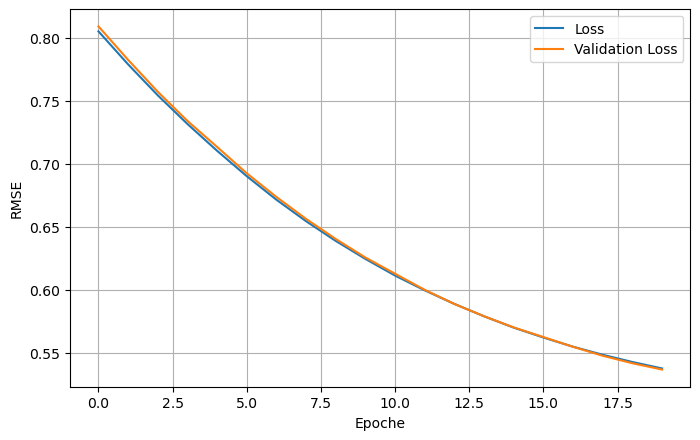

In [7]:
def plot_loss(history: tf.keras.callbacks.History):
    plt.figure(figsize=(8, 5), dpi=100)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoche')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

plot_loss(history)

### Evaluierung
Als nächstes wollen wir prüfen, wie gut unser Modell auf den Testdaten performt. Hierzu rufen wir die Methode `Model.evaluate()` auf. Als Ergbenis erhalten wir den Loss sowie die beiden Metriken RMSE und MAE zurück.

In [9]:
linear_results = linear_model.evaluate(x_test, y_test)
linear_results

500/500 [==============================] - 0s 40us/sample - loss: 0.5221 - mean_squared_error: 0.5235 - mean_absolute_error: 0.6330


[0.5220653896331787, 0.52345455, 0.63304394]

Wir wenden unser Modell nun an, um für den Testdatensatz die Zielwerte vorherzusagen. Diese können wir schließlich zusammen mit den tatsächlichen Funktionswerten der Sinusfunktion visualisieren.

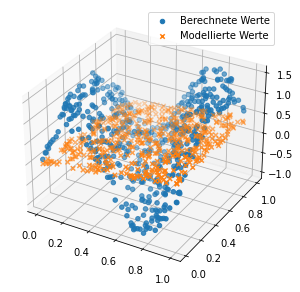

In [10]:
y_predicted = linear_model.predict(x_test)

def plot_predictions(x: np.ndarray, obs_y: np.ndarray, pred_y: np.ndarray):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x[:, 0], x[:, 1], obs_y, marker="o", label="Berechnete Werte")
    ax.scatter(x[:, 0], x[:, 1], pred_y, marker="x", label="Modellierte Werte")
    plt.legend()


plot_predictions(x=x_test, obs_y=y_test, pred_y=y_predicted)

Die vom Modell vorhergesagten Werte bilden zusammen eine Ebene im Raum. Hieran lässt sich erkennen, dass unser Modell lediglich in der Lage ist Linearitäten abzubilden.

## Dense Neural Network
### Training
Das lineare Modell war lediglich in der Lage eine lineare Zusammenhänge zu lernen. Bei der Annäherung der Sinusfunktion handelt es sich jedoch um eine nicht-lineare Aufgabe. Wir werden daher ein weiteres Neuronales Netz erstellen. Diesmal besitzt dieses jedoch mehrere Hidden Layer mit der Rectified Linear Unit (ReLU) Aktivierungsfunktion. Diese sorgt dafür, dass das Neuronale Netz Nichtlinearitäten abbilden kann.

In [11]:
# Definition des Neuronalen Netzes
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Bauen und Trainieren des NNs
history = compile_and_fit(model=dnn_model, inputs=x_train, targets=y_train,
                          validation=(x_valid, y_valid), batch_size=32, epochs=20)

Train on 2500 samples, validate on 500 samples
Epoch 1/20
2500/2500 [==============================] - 1s 252us/sample - loss: 0.4838 - mean_squared_error: 0.4817 - mean_absolute_error: 0.6237 - val_loss: 0.4209 - val_mean_squared_error: 0.4195 - val_mean_absolute_error: 0.5793
Epoch 2/20
2500/2500 [==============================] - 0s 48us/sample - loss: 0.3460 - mean_squared_error: 0.3454 - mean_absolute_error: 0.5205 - val_loss: 0.2368 - val_mean_squared_error: 0.2353 - val_mean_absolute_error: 0.4248
Epoch 3/20
2500/2500 [==============================] - 0s 47us/sample - loss: 0.1582 - mean_squared_error: 0.1569 - mean_absolute_error: 0.3389 - val_loss: 0.0827 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2418
Epoch 4/20
2500/2500 [==============================] - 0s 46us/sample - loss: 0.0646 - mean_squared_error: 0.0647 - mean_absolute_error: 0.1992 - val_loss: 0.0541 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1734
Epoch 5/20
2500/2500 [======

### Validierung
Auch hier wollen wir einmal den Fortschritt des Modells während des Trainings betrachten. Dabei erkennen wir, dass der Lernfortschritt bereits nach wenigen Epochen stagniert. Es würde daher ausreichen, das Modell lediglich über 5 Epochen zu trainieren. Mit jeder weiteren Epoche, würde das Modell verstärkt zur einem Overfitting eigen,

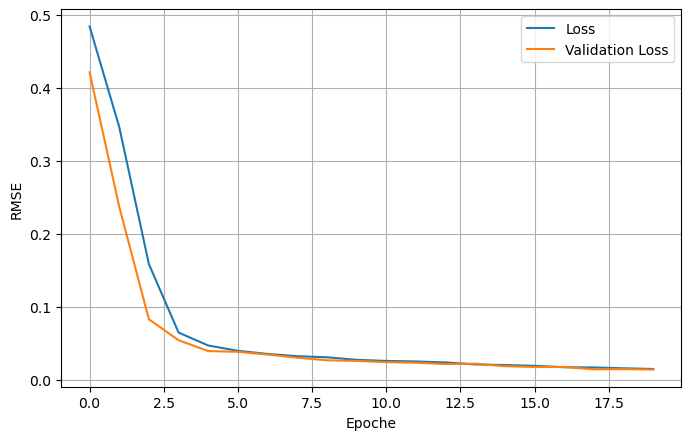

In [12]:
plot_loss(history)

### Test
Abschließend erfolgt wie zuvor die Evaluierung des Modells auf den Testdaten.

500/500 [==============================] - 0s 44us/sample - loss: 0.0131 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0657


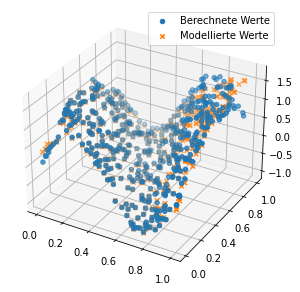

In [13]:

# Evaluierung und Speichern der Metriken
dnn_results = dnn_model.evaluate(x_test, y_test)
# Vorhersage der auf den Testdaten
y_predicted = dnn_model.predict(x_test)
# Plot der Vorhergesagten Werte mit den tatsächlichen Funktionswerten
plot_predictions(x=x_test, obs_y=y_test, pred_y=y_predicted)

Die vorhergesagten Werte passen sich gut an Sinuskurvenverlauf der tatsächlichen Werte an. Unser komplexeres Modell scheint die nichtlinearen Zusammenhänge tatsächlich gut abbilden zu können.

## Aufgaben
**1) Einführung in Tensorflow**  
Bearbeiten Sie interaktiv das Jupyter Notebook und versuchen Sie die Vorgehensweise des Trainieren eines Neuronalen Netzes nachzuvollziehen. Nutzen Sie zur Unterstützung auch die Dokumentation von Tensorflow bzw. die darunter liegende Bibliothek Keras. Insbesondere sei auf die folgenden Ressourcen verwiesen:
* https://www.tensorflow.org/guide/keras/sequential_model
* https://www.tensorflow.org/guide/keras/train_and_evaluate
* https://www.tensorflow.org/tutorials/keras/regression

**2) Trainieren eines eigenen Modells**  
Definieren Sie ein eigenes sequentielles Modell und variieren Sie dabei verschiedene Parameter des Neuronalen Netzes:
* Anzahl der DenseLayer
* Anzahl der Neuronen in einem Layer
* Aktivierungsfunktion (eine Übersicht der implementierten Aktivierungsfunktionen in Tensorflow finden Sie unter: https://www.tensorflow.org/api_docs/python/tf/keras/activations)

Übeprüfen Sie, inwiefern sich die Anpasssungen auf den Trainingsfortschritt und die Qualität des Modells auswirken.

**3) Evaluation**  
Werten Sie die Evaluationsmetriken des linearen Modells, des DNN Models und ihres eigenen Modells aus, indem Sie die Metriken in ein pandas DataFrame übertragen und angemessen mit matplotlib visualisieren.

**4) Modellierung einer eigenen Funktion**  
Definieren Sie einmal eine beliebige komplexe nicht-lineare Funktion und versuchen Sie diese wie zuvor mit Hilfe eines Neuronalen Netzes anzunähern.